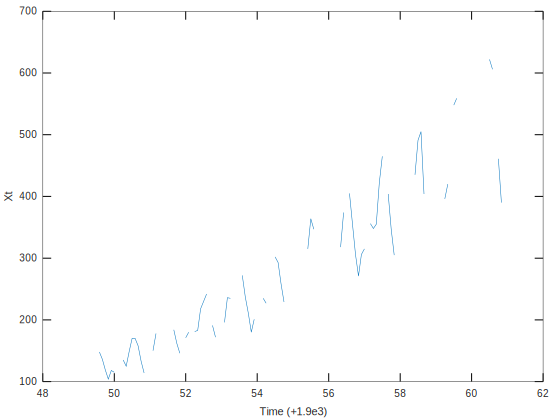

In [5]:
data = csvread("flights.csv");
T = data(2:end,1);
X = data(2:end,2);
mu = mean(X);
s = std(X);
miss = find(X==0);
obs = find(X!=0);
X(X == 0) = NaN; 
plot((T-1900),X);
xlabel("Time (+1.9e3)");
ylabel("Xt");
N = numel(X);

In [6]:
for i = 1:N
    if(isnan(X(i)))
        X(i)=normrnd(mu,s);
    endif
endfor

M = 4; 

for z = 1:10

    G_x = zeros(N-M,M);

    for i = 1:(N-M)
        for k = 1:M
            G_x(i,k) = X(M+i-k);
        endfor
    endfor

    [Q, R] = qr(G_x);
    b = inv(Q)*X(M+1:N, end);
    A = linsolve(R, b);

    G_a = zeros(N-M, N);

    for i = 1:(N-M)
        for k = 1:M
            G_a(i,i+k-1) = A(M+1-k);
        endfor
        G_a(i, i+M) = -1;
    endfor
        
    G_a_m = G_a;
    
    G_a(:,[miss]) =[];
    G_a_m(:,[obs]) =[];
    G_a = times(G_a, -1);

    [Q, R] = qr(G_a_m); 
    b = inv(Q)*(G_a*X(obs));
    X_mi = linsolve(R, b);
    
    X(miss)=X_mi;

endfor

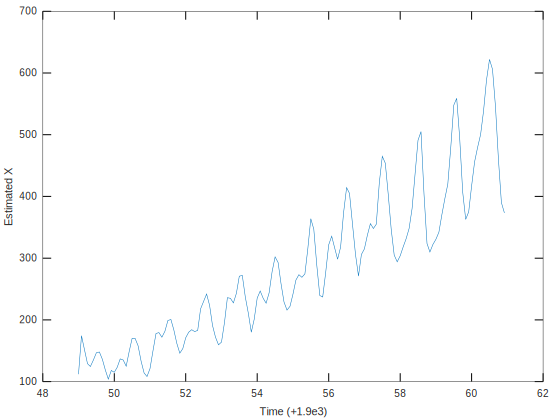

In [11]:
plot(T - 1900, X);
xlabel("Time (+1.9e3)");
ylabel("Estimated X");

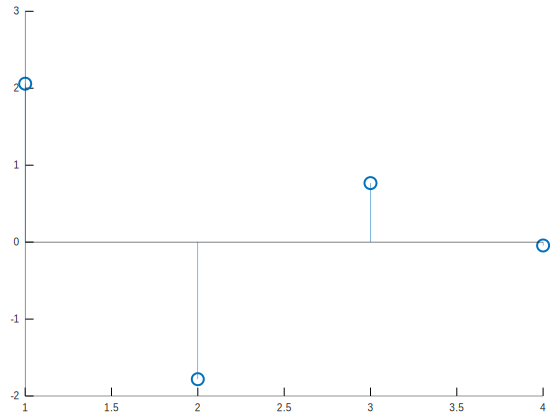

In [12]:
stem(A)